In [1]:
import requests
import pandas as pd
from vega_datasets import data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.linear_model import LassoLars
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Project and goals

# Plan and breakdown

# Acquisition and Prep

In [2]:
df , df_time = wrangle.get_snow_crabs()

In [3]:
train, val , test = wrangle.train_val_test(df)

In [4]:
df_time.head()

,cpue
year,
1975-12-31,76198.576087
1976-12-31,42832.097938
1977-12-31,107108.323810
1978-12-31,31497.604430
1979-12-31,59850.594595


# Explore

In [5]:
yr_labels = []
for yr in range(1975, 2019):
    yr_labels.append(f'{yr}')

In [6]:
plot_001 = pd.DataFrame(train.groupby('year').mean())


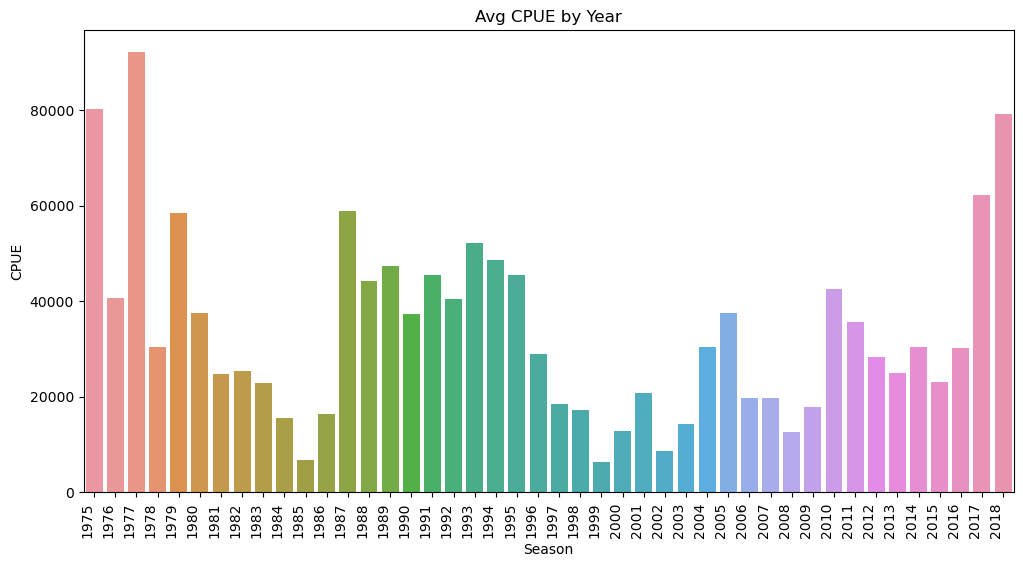

In [7]:
plt.subplots(figsize = (12,6))
fig = sns.barplot(data = plot_001, x = plot_001.index, y = 'cpue')

plt.title('Avg CPUE by Year')
plt.xlabel('Season')
plt.ylabel('CPUE')
fig.set_xticklabels(labels=yr_labels, rotation=90, ha='right')
plt.show()

In [8]:
train_lim = train[train['cpue'] < 600000]
train_lim = train_lim[train_lim['bottom_depth'] < 200]
train_lim = train_lim[train_lim['bottom_temperature'] < 8.5]

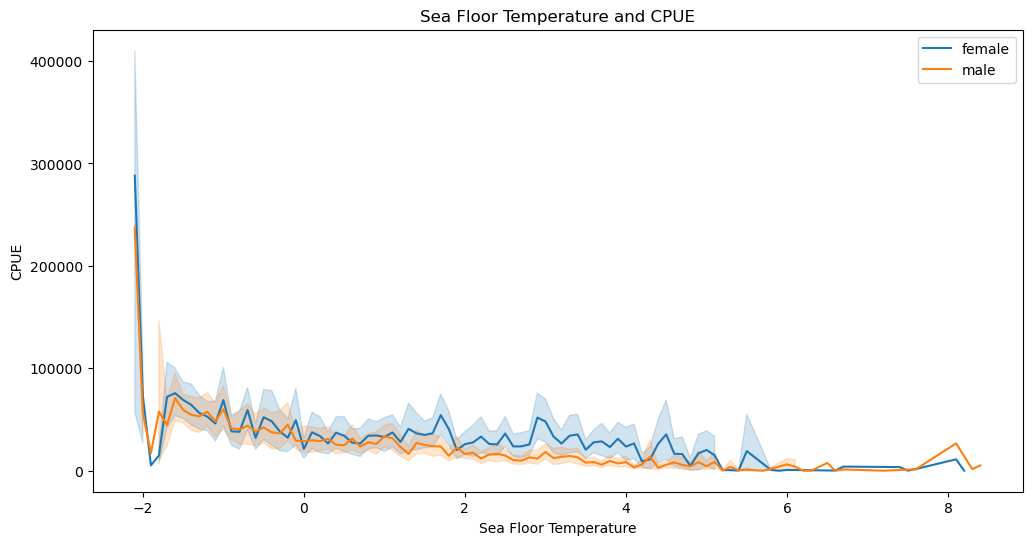

In [9]:
plt.subplots(figsize = (12,6))
sns.lineplot(data=train_lim[train_lim['sex'] == 'female'], x="bottom_temperature", y="cpue", label = 'female')
sns.lineplot(data=train_lim[train_lim['sex'] == 'male'], x="bottom_temperature", y="cpue", label = 'male')
plt.title('Sea Floor Temperature and CPUE')
plt.xlabel('Sea Floor Temperature')
plt.ylabel('CPUE')
plt.legend()
plt.show()


In [10]:
stats.spearmanr(train['cpue'], train['bottom_temperature'])

SpearmanrResult(correlation=-0.38732964457546915, pvalue=0.0)

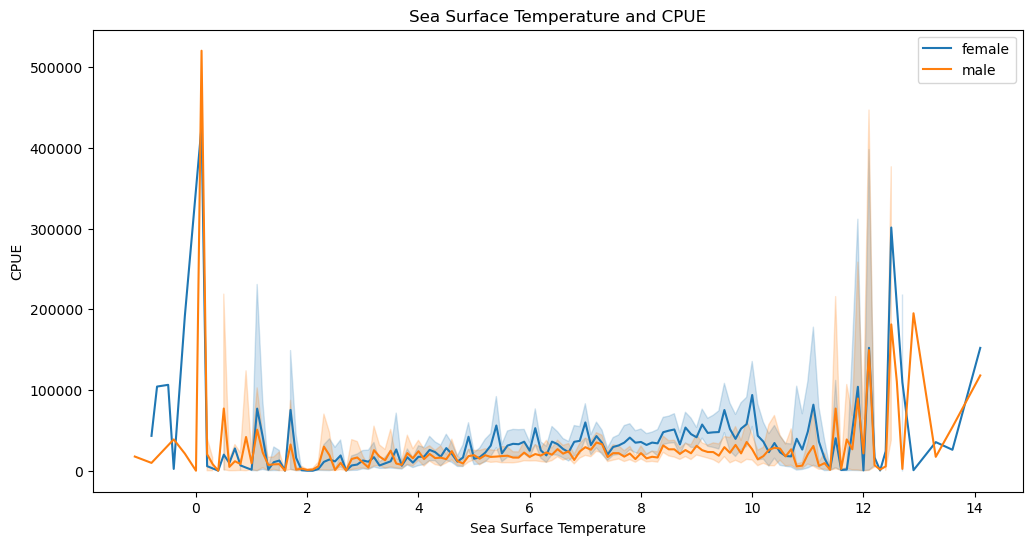

In [11]:
plt.subplots(figsize = (12,6))
sns.lineplot(data=train_lim[train_lim['sex'] == 'female'], x="surface_temperature", y="cpue", label = 'female')
sns.lineplot(data=train_lim[train_lim['sex'] == 'male'], x="surface_temperature", y="cpue", label = 'male')
plt.title('Sea Surface Temperature and CPUE')
plt.xlabel('Sea Surface Temperature')
plt.ylabel('CPUE')
plt.legend()
plt.show()

In [12]:
stats.spearmanr(train['cpue'], train['surface_temperature'])

SpearmanrResult(correlation=0.0906877885365029, pvalue=2.5119818381322743e-24)

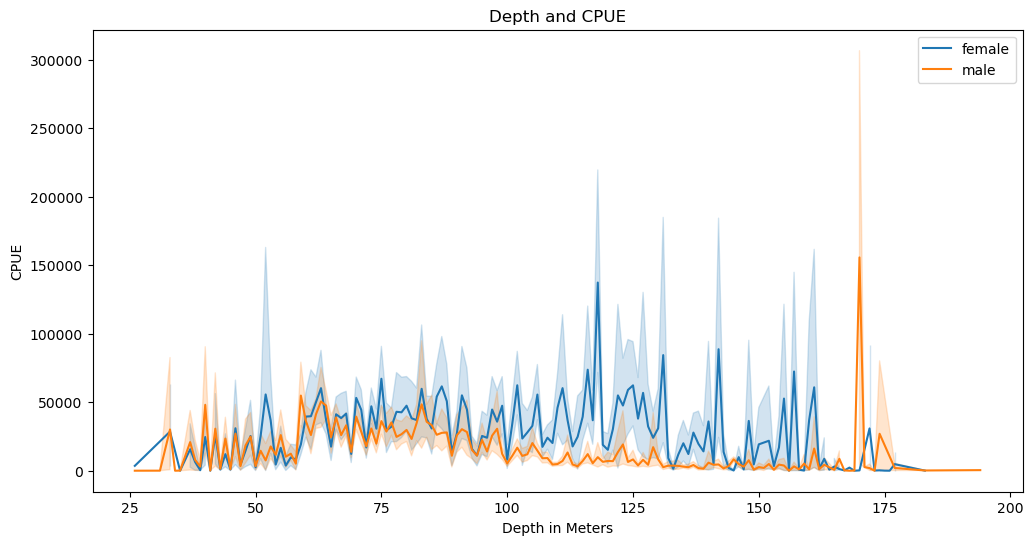

In [13]:
plt.subplots(figsize = (12,6))
sns.lineplot(data=train_lim[train['sex'] == 'female'] , x="bottom_depth", y="cpue", label = 'female')
sns.lineplot(data=train_lim[train['sex'] == 'male'] , x="bottom_depth", y="cpue", label = 'male')
plt.title('Depth and CPUE')
plt.xlabel('Depth in Meters')
plt.ylabel('CPUE')
plt.legend()
plt.show()

In [14]:
stats.spearmanr(train['cpue'], train['bottom_depth'])

SpearmanrResult(correlation=-0.1003311053815531, pvalue=1.966968227123919e-29)

# Exploration Takeaways

# Modeling

In [15]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [16]:
df_time = pd.DataFrame(df_time.resample('y')['cpue'].mean())
df_time.head()

,cpue
year,
1975-12-31,76198.576087
1976-12-31,42832.097938
1977-12-31,107108.323810
1978-12-31,31497.604430
1979-12-31,59850.594595


In [18]:
train_t, val_t, test_t = modeling.time_split(df_time)

In [19]:
train_t.head()

,cpue
year,
1975-12-31,76198.576087
1976-12-31,42832.097938
1977-12-31,107108.323810
1978-12-31,31497.604430
1979-12-31,59850.594595


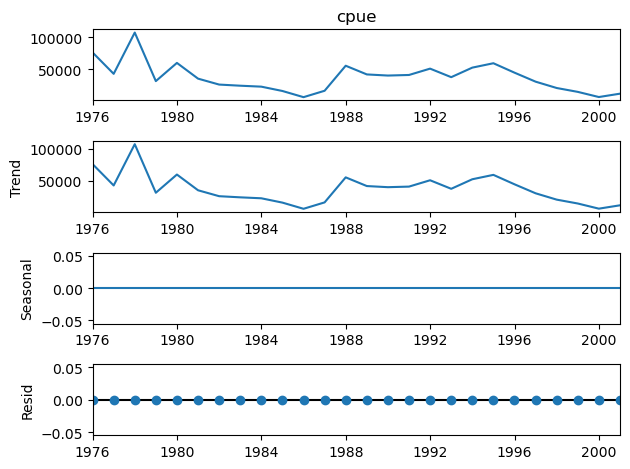

In [20]:
sm.tsa.seasonal_decompose(train_t['cpue'].resample('1y').mean()).plot()
None

In [21]:
baseline = round(train_t['cpue'].mean(), 4)

In [22]:
yhat_df = modeling.make_baseline_predictions(baseline, val_t)

cpue -- RMSE: 19589


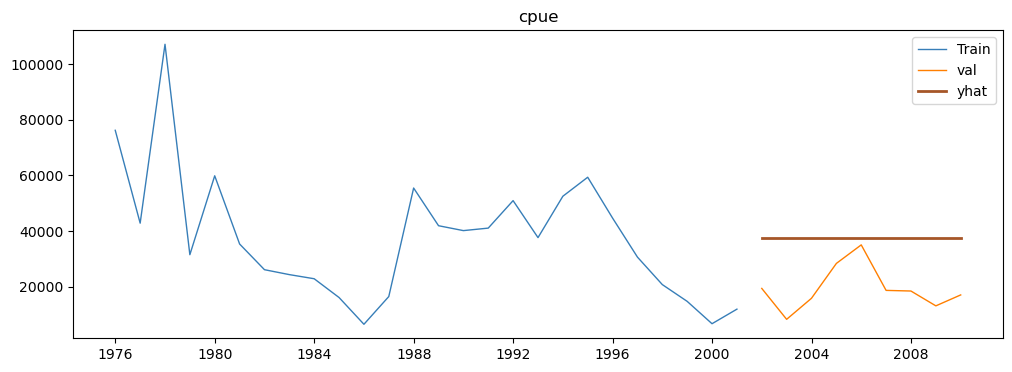

In [23]:
modeling.plot_and_eval('cpue', train_t, val_t, yhat_df)

In [24]:
eval_df = modeling.append_eval_df('simple_mean', 'cpue', val_t, yhat_df, eval_df)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0


In [25]:
hst_cpue = ExponentialSmoothing(train_t.cpue, seasonal_periods=9, 
                                trend='add', seasonal='add', damped = True).fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [26]:
hst_preds = hst_cpue.forecast(val_t.shape[0])

In [27]:
hst_preds[hst_preds < 0] = 0

In [28]:
yhat_df = pd.DataFrame({'cpue': hst_preds},
                          index=val_t.index)

cpue -- RMSE: 12265


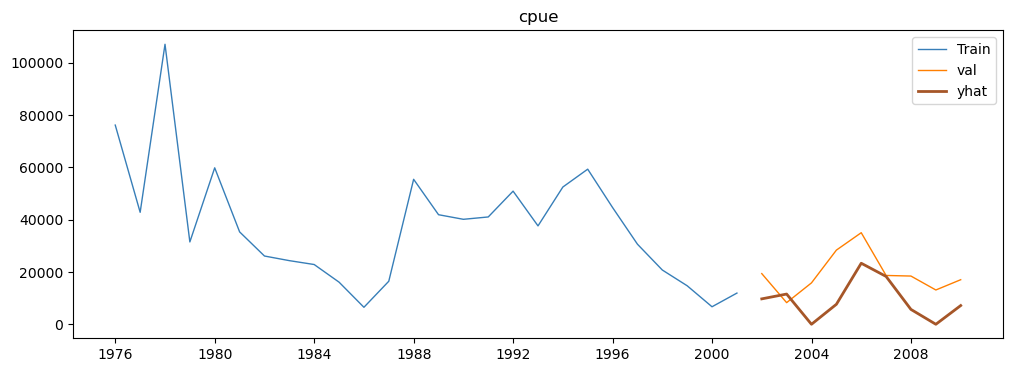

In [29]:
modeling.plot_and_eval('cpue', train_t, val_t, yhat_df)

In [30]:
eval_df = modeling.append_eval_df('holts_seasonal', 'cpue', val_t, yhat_df, eval_df)


In [31]:
eval_df.head()

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0
1,holts_seasonal,cpue,12265.0


In [32]:
x_train, y_train, x_val, y_val, x_test, y_test = modeling.modeling_prep(train, val, test)

In [33]:
preds_df = pd.DataFrame(train['cpue'])

In [34]:
tweedie = TweedieRegressor(power = 1, alpha = 1)

In [35]:
tweedie.fit(x_train, y_train)

TweedieRegressor(alpha=1, power=1)

In [36]:
tweedie_preds = tweedie.predict(x_train)

In [37]:
tweedie_preds[tweedie_preds < 0] = 0

In [38]:
preds_df['baseline'] = preds_df['cpue'].mean()
preds_df['tweedie'] = tweedie_preds


In [39]:
tweedie_rmse = sqrt(mean_squared_error(preds_df['tweedie'], preds_df['cpue']))

In [40]:
eval_df = eval_df.append({'model_type':'Tweedie', 'target_var':'cpue','rmse':tweedie_rmse}, ignore_index=True)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.00000
1,holts_seasonal,cpue,12265.00000
2,Tweedie,cpue,83310.55676


In [41]:
pf = PolynomialFeatures(degree = 2)
pf.fit(x_train, y_train)
x_poly=pf.transform(x_train)
lm = LinearRegression()
lm.fit(x_poly, y_train)
poly_preds = lm.predict(x_poly)
poly_preds[poly_preds < 0] = 0

In [42]:
preds_df['poly_preds'] = poly_preds
preds_df.head()

,cpue,baseline,tweedie,poly_preds
4224,77,31652.13648,33885.844480,11154.0
1303,21400,31652.13648,19989.219846,11442.0
9406,3413,31652.13648,2052.030987,0.0
6165,84660,31652.13648,35218.111781,54546.0
1646,3281,31652.13648,13400.116563,67730.0


In [43]:
poly_rmse = sqrt(mean_squared_error(preds_df['poly_preds'], preds_df['cpue']))

In [44]:
eval_df = eval_df.append({'model_type':'Poly_Reg', 'target_var':'cpue','rmse':poly_rmse}, ignore_index=True)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.000000
1,holts_seasonal,cpue,12265.000000
2,Tweedie,cpue,83310.556760
3,Poly_Reg,cpue,79415.132597


In [47]:
yhat_df = pd.DataFrame({'cpue': hst_cpue.forecast(val_t.shape[0] + test_t.shape[0])})
yhat_df=yhat_df['2010-12-31':'2018-12-31']



,cpue
2010-12-31,1317.450392
2011-12-31,3244.877449
2012-12-31,-9290.818744
2013-12-31,-505.832268
2014-12-31,15277.701778


In [49]:
rmse_temp_total = sqrt(mean_squared_error(test_t['cpue'], yhat_df['cpue']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-temp total:  43468.69397315249


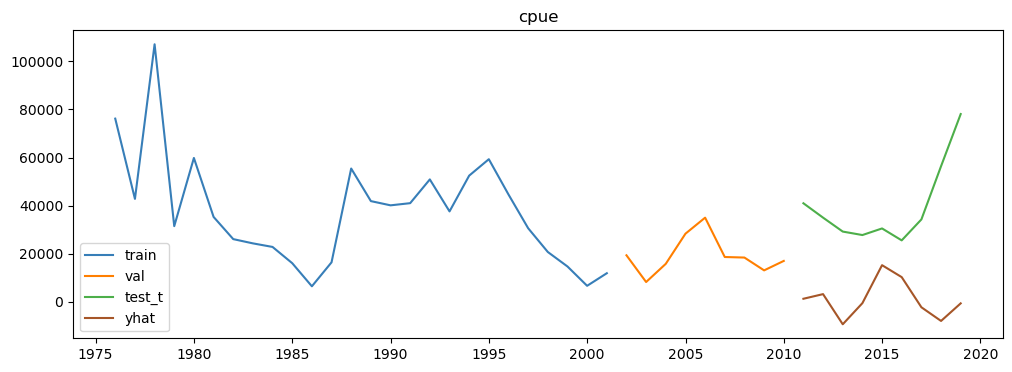

In [50]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-temp total: ', rmse_temp_total)
modeling.final_plot('cpue', train_t, val_t, test_t, yhat_df)